### Researchers say such emotion detectors don’t work very well.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [1]:
!python -m pip install -U -r server/requirements.txt

Requirement already up-to-date: pip in c:\python\python37\lib\site-packages (from -r server/requirements.txt (line 1)) (20.0.2)
  Using cached setuptools-45.2.0-py3-none-any.whl (584 kB)
Requirement already up-to-date: wheel in c:\python\python37\lib\site-packages (from -r server/requirements.txt (line 3)) (0.34.2)
  Using cached tqdm-4.42.1-py2.py3-none-any.whl (59 kB)
Requirement already up-to-date: numpy in c:\python\python37\lib\site-packages (from -r server/requirements.txt (line 6)) (1.18.1)
  Using cached pandas-1.0.1-cp37-cp37m-win_amd64.whl (9.0 MB)
Requirement already up-to-date: Click==7.0 in c:\python\python37\lib\site-packages (from -r server/requirements.txt (line 8)) (7.0)
Requirement already up-to-date: Flask==1.1.1 in c:\python\python37\lib\site-packages (from -r server/requirements.txt (line 9)) (1.1.1)
Requirement already up-to-date: itsdangerous==1.1.0 in c:\python\python37\lib\site-packages (from -r server/requirements.txt (line 10)) (1.1.0)
Requirement already up-

In [1]:
import cv2, sys, os, joblib
from glob import glob
from tqdm.notebook import trange, tqdm
import numpy as np

# !pip instal dlib # how to from https://github.com/ageitgey/face_recognition/issues/175
# !pip install face_recognition
import dlib # Landmarks algorithme
import math
from skimage import feature 
from skimage.feature import hog
import random
import pandas as pd

from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import KFold, ShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, f1_score

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from ReliefF import ReliefF # Reduction du dimentionnalité

import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
%matplotlib inline
import seaborn as sns # Visualisation de données
# home = '/content/drive/My Drive/Colab Notebooks/Facial-Expression-Detection/'
home = 'D:/WISD/S3/Image_Mining/Facial-Expression-Detection/'

In [58]:
from jupyterthemes import jtplot
jtplot.style()

## Face Extractor ##

<p>
Creation d'un modele qui permet l'extraction de visage en utilisant l'algorithme de Viola Jones

shema xml from : https://github.com/opencv/opencv/tree/master/data/haarcascades
</P>

In [59]:
faceDet = cv2.CascadeClassifier(home+"haarcascades/haarcascade_frontalface_alt.xml")
faceDet2 = cv2.CascadeClassifier(home+"haarcascades/haarcascade_frontalface_alt2.xml")
faceDet4 = cv2.CascadeClassifier(home+"haarcascades/haarcascade_frontalface_default.xml")
faceDet3 = cv2.CascadeClassifier(home+"haarcascades/haarcascade_frontalface_alt_tree.xml")

def face_extractor(img_path, flag = False):
    gray = cv2.imread(img_path,0)
    # Detection des visages : il peut detecter des données aberantes(un objet n'est pas clair peut etre considerer
    # comme un visage)
    faces = faceDet.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
    if len(faces) < 1:
        faces = faceDet2.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
        print(2)
        if len(faces) < 1:
            print(3)
            faces = faceDet3.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
            if len(faces) < 1:
                print(4)
                faces = faceDet4.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=10, minSize=(48, 48), flags=cv2.CASCADE_SCALE_IMAGE)
                if len(faces) < 1:
                    return None
    # On s'intersse au visage de grande dimension qui est le plus proche dans l'image       
    max_surface = 0
    x, y, w,h = 0, 0, 0, 0
    for (xi, yi, wi,hi) in faces:
        if wi*hi > max_surface:
            x, y, w,h = xi, yi, wi,hi
            max_surface = wi*hi
    if(w*h!=0):
        #si h = 0 ou w = 0 (rien detecté), notre fonction retourne None,
        # sinon on bien determiner le visage donc on l'extract selon le nouveau hauteur et largeur
        if flag:
            face_seg = cv2.imread(img_path)[y:y+h, x:x+w]
        else:
            face_seg = gray[y:y+h, x:x+w]
            # on fait la normalisation de hauteur et de largeur  des images h=96 et w=96
            face_seg = cv2.resize(face_seg, (96, 96), interpolation = cv2.INTER_AREA) # Resize face so all images have same size
        return face_seg
    
    return None

In [60]:
def pltC(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def plot_img(list_img):
    fig, ax = plt.subplots(1, len(list_img), figsize=(22, 8),
                       subplot_kw=dict(xticks=[], yticks=[]))
    
    for i, (img, title) in enumerate(list_img):
        ax[i].imshow(img, cmap='gray')
        ax[i].set_title(title)
    plt.show()

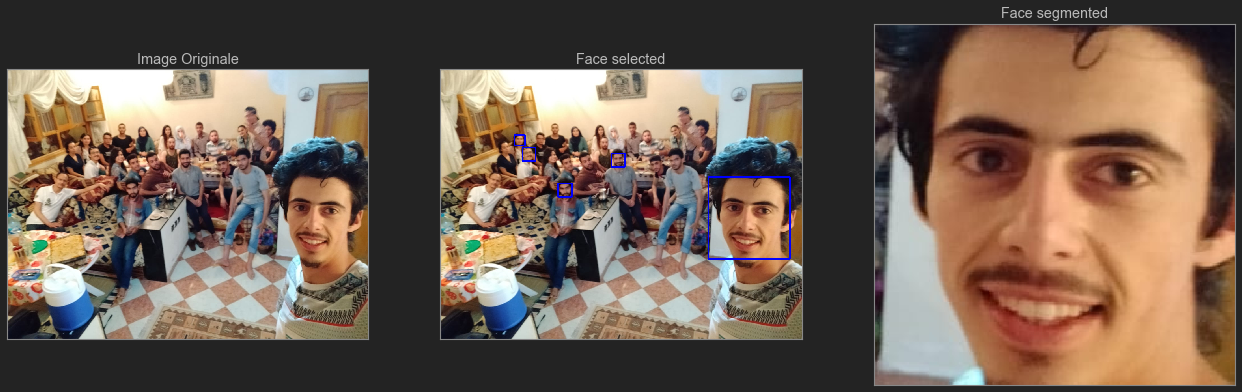

In [61]:
img_path = home+'images/wisd.jpg'
original_img = cv2.imread(img_path)
img = original_img.copy()

img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
faces = faceDet.detectMultiScale(img_gray , scaleFactor=1.1, minNeighbors=10, minSize=(5, 5), flags=cv2.CASCADE_SCALE_IMAGE)

for (x, y , w ,h) in faces:
    cv2.rectangle(img, (x,y), (x+w, y+h), (255, 0 , 0), 3)

max_surface = 0
x, y , w ,h = 0,0,0,0
for (xi, yi , wi ,hi) in faces:
    if wi*hi > max_surface:
        x, y , w ,h = xi, yi , wi ,hi
        max_surface = wi*hi
if(w*h==0):
    print('[no face detected]')
    sys.exit()
face_seg = original_img[y:y+h,x:x+w]

plot_img([(pltC(original_img), 'Image Originale'), (pltC(img), 'Face selected'), (pltC(face_seg), 'Face segmented')])

## Emotion Recognition using Facial Landmarks, Python, DLib and OpenCV ##
***

This example program shows how to find frontal human faces in an image and
estimate their pose.  The pose takes the form of 68 landmarks.  These are
points on the face such as the corners of the mouth, along the eyebrows, on
the eyes, and so forth.

The face detector we use is made using the classic Histogram of Oriented
Gradients (HOG) feature combined with a linear classifier, an image pyramid,
and sliding window detection scheme.  The pose estimator was created by
using dlib's implementation of the paper: " One Millisecond Face Alignment with an Ensemble of Regression Trees by Vahid Kazemi and Josephine Sullivan, CVPR 2014 ", and was trained on the iBUG 300-W face landmark dataset (see
https://ibug.doc.ic.ac.uk/resources/facial-point-annotations/).
    
You can get the trained model file from:
http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2.
Note that the license for the iBUG 300-W dataset excludes commercial use.
So you should contact Imperial College London to find out if it's OK for
you to use this model file in a commercial product.


In [62]:
# from https://github.com/lincolnhard/head-pose-estimation/blob/master/video_test_shape.py

import cv2
import dlib
import numpy as np
from imutils import face_utils

face_landmark_path = home+'shape_predictor_68_face_landmarks.dat'

K = [6.5308391993466671e+002, 0.0, 3.1950000000000000e+002,
     0.0, 6.5308391993466671e+002, 2.3950000000000000e+002,
     0.0, 0.0, 1.0]
D = [7.0834633684407095e-002, 6.9140193737175351e-002, 0.0, 0.0, -1.3073460323689292e+000]

cam_matrix = np.array(K).reshape(3, 3).astype(np.float32)
dist_coeffs = np.array(D).reshape(5, 1).astype(np.float32)

object_pts = np.float32([[6.825897, 6.760612, 4.402142],
                         [1.330353, 7.122144, 6.903745],
                         [-1.330353, 7.122144, 6.903745],
                         [-6.825897, 6.760612, 4.402142],
                         [5.311432, 5.485328, 3.987654],
                         [1.789930, 5.393625, 4.413414],
                         [-1.789930, 5.393625, 4.413414],
                         [-5.311432, 5.485328, 3.987654],
                         [2.005628, 1.409845, 6.165652],
                         [-2.005628, 1.409845, 6.165652],
                         [2.774015, -2.080775, 5.048531],
                         [-2.774015, -2.080775, 5.048531],
                         [0.000000, -3.116408, 6.097667],
                         [0.000000, -7.415691, 4.070434]])

reprojectsrc = np.float32([[10.0, 10.0, 10.0],
                           [10.0, 10.0, -10.0],
                           [10.0, -10.0, -10.0],
                           [10.0, -10.0, 10.0],
                           [-10.0, 10.0, 10.0],
                           [-10.0, 10.0, -10.0],
                           [-10.0, -10.0, -10.0],
                           [-10.0, -10.0, 10.0]])

line_pairs = [[0, 1], [1, 2], [2, 3], [3, 0],
              [4, 5], [5, 6], [6, 7], [7, 4],
              [0, 4], [1, 5], [2, 6], [3, 7]]


def get_head_pose(shape):
    image_pts = np.float32([shape[17], shape[21], shape[22], shape[26], shape[36],
                            shape[39], shape[42], shape[45], shape[31], shape[35],
                            shape[48], shape[54], shape[57], shape[8]])

    _, rotation_vec, translation_vec = cv2.solvePnP(object_pts, image_pts, cam_matrix, dist_coeffs)

    reprojectdst, _ = cv2.projectPoints(reprojectsrc, rotation_vec, translation_vec, cam_matrix,
                                        dist_coeffs)

    reprojectdst = tuple(map(tuple, reprojectdst.reshape(8, 2)))

    # calc euler angle
    rotation_mat, _ = cv2.Rodrigues(rotation_vec)
    pose_mat = cv2.hconcat((rotation_mat, translation_vec))
    _, _, _, _, _, _, euler_angle = cv2.decomposeProjectionMatrix(pose_mat)

    return reprojectdst, euler_angle


def main():
    # return
    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print("Unable to connect to camera.")
        return
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(face_landmark_path)

    while cap.isOpened():
        ret, frame = cap.read()
        frame = cv2.flip(frame, 1)
        if ret:
            face_rects = detector(frame, 0)
            
            if len(face_rects) > 0:
                shape = predictor(frame, face_rects[0])
                shape = face_utils.shape_to_np(shape)

                reprojectdst, euler_angle = get_head_pose(shape)
                
                for (x, y) in shape:
                    cv2.circle(frame, (x, y), 1, (0, 0, 255), -1)

                for start, end in line_pairs:
                    cv2.line(frame, reprojectdst[start], reprojectdst[end], (0, 0, 255))

                cv2.putText(frame, "X: " + "{:7.2f}".format(euler_angle[0, 0]), (20, 20), cv2.FONT_HERSHEY_SIMPLEX,
                            0.75, (0, 0, 0), thickness=2)
                cv2.putText(frame, "Y: " + "{:7.2f}".format(euler_angle[1, 0]), (20, 50), cv2.FONT_HERSHEY_SIMPLEX,
                            0.75, (0, 0, 0), thickness=2)
                cv2.putText(frame, "Z: " + "{:7.2f}".format(euler_angle[2, 0]), (20, 80), cv2.FONT_HERSHEY_SIMPLEX,
                            0.75, (0, 0, 0), thickness=2)

            cv2.imshow("demo", frame)

            key = cv2.waitKey(20) 
            if key == 27: # hadi hiyya Esc
                cap.release()
                cv2.destroyAllWindows()
                sys.exit()
                break


if __name__ == '__main__':
    main()

SystemExit: 

C:\Python\Python37\lib\site-packages\IPython\core\interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [63]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(home+"shape_predictor_68_face_landmarks.dat")


def draw_face_landmarks(img_path, flag = False):
    img = cv2.imread(img_path)
    image = cv2.imread(img_path, 0)
    detections = detector(image, 1)
    best_face = 0

    if len(detections) > 1:
        # On s'interisse au visage de grande dimension qui est le plus proche dans l'image
        max_surface = 0
        xm, ym, wm, hm = 0, 0, 0, 0
        for i, face in enumerate(detections):
            # Finding points for rectangle to draw on face
            xi, yi, wi, hi = face.left(), face.top(), face.width(), face.height()
            if wi*hi > max_surface:
                xm, ym, wm, hm = xi, yi, wi, hi
                max_surface = wi*hi
                best_face = i
    elif len(detections) < 1:
        return None

    for f, face in enumerate(detections):
        # Draw Facial Landmarks with the predictor class
        shape = predictor(image, face)
        xlist = []
        ylist = []
        for i in range(68):  # Store X and Y coordinates in two lists
            xlist.append(int(shape.part(i).x))
            ylist.append(int(shape.part(i).y))

        def draw_line(x, y, g=True):
            if g:
                cv2.line(img, (xlist[x], ylist[x]),
                         (xlist[y], ylist[y]), (0, 255, 0), 1)
            else:
                cv2.line(img, (xlist[x], ylist[x]),
                         (xlist[y], ylist[y]), (155, 0, 247), 1)
        g = False
        if f == best_face:
            g = True

        for i in range(16):
            draw_line(i, i+1, g)
        for i in range(17, 21):
            draw_line(i, i+1, g)
        for i in range(22, 26):
            draw_line(i, i+1, g)
        for i in range(36, 41):
            draw_line(i, i+1, g)
        draw_line(36, 41, g)
        for i in range(42, 47):
            draw_line(i, i+1, g)
        draw_line(42, 47, g)

        for i in range(27, 35):
            draw_line(i, i+1, g)
        draw_line(30, 35, g)

        for i in range(48, 59):
            draw_line(i, i+1, g)
        draw_line(48, 59, g)
        for i in range(60, 67):
            draw_line(i, i+1, g)
        draw_line(60, 67, g)

    # Drawing simple rectangle around found faces
    if flag and xm is not None:
        cv2.rectangle(img, (xm, ym), (xm + wm, ym + hm), (0, 0, 255), 2)
#     cv2.imwrite(home+'4_2.png', img)
    return img

In [64]:
def get_face_landmarks(img_path, flag=False):
    """
    Une  autre façon de detecter le visage.
    """
    image = cv2.imread(img_path, 0)
    try:
        detections = detector(image, 1)
    except:
        return None
    
    # On s'interisse au visage de grande dimension qui est le plus proche dans l'image
    best_face_id = 0
    if len(detections) > 1:
        max_surface = 0
        xm, ym, wm, hm = 0, 0, 0, 0
        for i, face in enumerate(detections):
            # Finding points for rectangle to draw on face
            xi, yi, wi, hi = face.left(), face.top(), face.width(), face.height()
            if wi*hi > max_surface:
                xm, ym, wm, hm = xi, yi, wi, hi
                max_surface = wi*hi
                best_face_id = i
    elif len(detections) < 1:
        return None
    
    # Draw Facial Landmarks with the predictor class
    shape = predictor(image, detections[best_face_id])
    xlist = []
    ylist = []
    for i in range(68):  # Store X and Y coordinates in two lists
        xlist.append(int(shape.part(i).x))
        ylist.append(int(shape.part(i).y))
    # Estimation de visage
    xmin, xmax, ymin, ymax = np.min(xlist), np.max(
        xlist), np.min(ylist), np.max(ylist)
    w, h = xmax-xmin, ymax-ymin
    if ymin <= h/3:
        ymin = 0
    else:
        ymin -= int(h/3)

    if xmin <= w/5:
        xmin = 0
    else:
        xmin -= int(w/5)

    wight = image.shape[1]
    if xmax >= wight-w/5:
        xmax = wight
    else:
        xmax += int(w/5)
    
    if flag:
        face_seg = cv2.imread(img_path)[ymin:ymax, xmin:xmax]
    else:
        face_seg = image[ymin:ymax, xmin:xmax]
        face_seg = cv2.resize(face_seg, (96, 96), interpolation = cv2.INTER_AREA)
    return face_seg

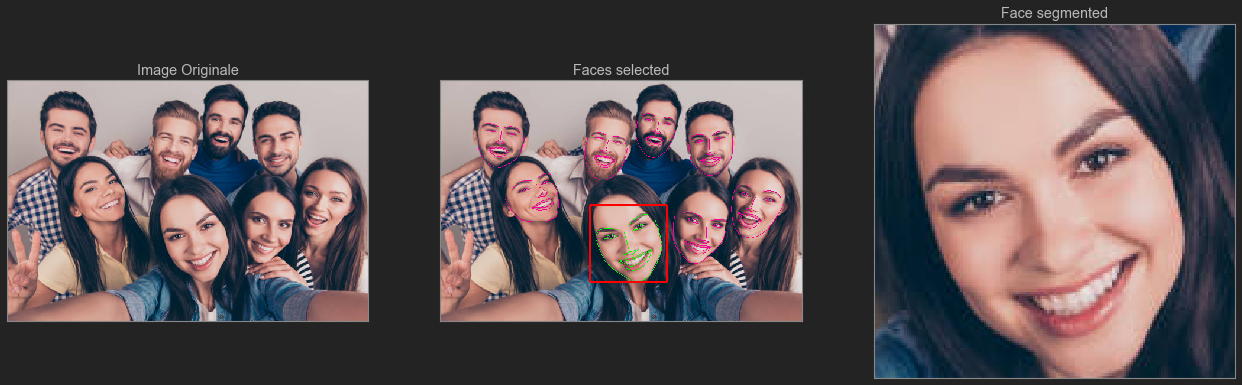

In [65]:
img_path = home+'images/4.png'
img = cv2.imread(img_path)
plot_img([(pltC(img), 'Image Originale'), (pltC(draw_face_landmarks(
    img_path, True)), 'Faces selected'), (pltC(get_face_landmarks(img_path, True)), 'Face segmented')])

In [66]:
def our_ft_landmark(X, Y):
    """ 
    Dans cette fonction on a utilisé les points de landmark pour l'extraction features cela on calculant des ongles 
    entre les points des parties suivantes: entre le nez et les yeux, les yeux et les sourcils et la bouche et le nez ... 
    Apres ce calcul on fait la normalisation de données pour gerer les problemes liées à la difference des visages humains.
    """
    def get_degre(i,j):
        myradians = math.atan2(Y[i]-Y[j], X[i]-X[j])
        return math.degrees(myradians)

    f_x = [30,30,30,30,30,30,21,17,22,43,42,38,36,62,51,48,51]
    f_y = [26,54,17,48,22,21,22,21,26,47,45,40,39,66,57,54,30]
    features = []

    for i,j in zip(f_x,f_y):
        features.append(np.linalg.norm( (X[i]-X[j],Y[i]-Y[j]) ) )

    features = list(features / np.mean(features))# normalisation des données
    
    features2 = []
    features2.append((get_degre(30,26)-90))
    features2.append((get_degre(30,22)-90))
    features2.append((90-get_degre(30,17)))
    features2.append((90-get_degre(30,21)))
    features2.append((get_degre(30,54)*-1-90))
    features2.append((90-get_degre(30,48)*-1))

    features.extend(np.array(features2)/100)
    return features

<p>
Dans cette fonction on recupere les points de landmarks et les features (our_ft_landmark) 
</p>

In [67]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(home+"shape_predictor_68_face_landmarks.dat")


def get_landmarks(image): # from https://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/
    """
    Dans cette fonction on recupere les points de landmarks et les features (our_ft_landmark) 
    """
    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    detections = detector(image, 1)
    if len(detections) < 1: # Number of faces detected = 0
        # print("Number of faces detected: {}".format(len(detections)))
        return None
    # Draw Facial Landmarks with the predictor class
    shape = predictor(image, detections[0])
    xlist = []
    ylist = []
    for i in range(68):  # Store X and Y coordinates in two lists
        xlist.append(float(shape.part(i).x))
        ylist.append(float(shape.part(i).y))

    landmarks_vectorised = []
    landmarks_vectorised = our_ft_landmark(xlist, ylist)# Extaraction des features

    xmean = np.mean(xlist)
    ymean = np.mean(ylist)
    xcentral = [(x-xmean) for x in xlist]
    ycentral = [(y-ymean) for y in ylist]
    
    for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
        landmarks_vectorised.append(w)
        landmarks_vectorised.append(z)
#       landmarks_vectorised.append(x)
#       landmarks_vectorised.append(y)
        meannp = np.asarray((ymean, xmean))
        coornp = np.asarray((z, w))
        dist = np.linalg.norm(coornp-meannp)# Distance euclidienne
        landmarks_vectorised.append(dist)
        landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))# Calcule de l'ongle entre le moyenne et un point

    return landmarks_vectorised

In [68]:
def get_local_binary_pattern(image, numPoints, radius, eps=1e-7):
    """
    ** Extraction des Features en se basant sur la texture: **
    La méthode LBP contient des informations sur la distribution des micro-motifs locaux.

    Les expressions faciales peuvent être considérées comme une composition de micro-motifs 
    qui peuvent être efficacement décrits par les fonctionnalités LBP. 

    Un histogramme LBP présente uniquement les occurrences des micro-motifs sans aucune indication sur leur emplacement.

    @args : image (image à traiter)
    @return hist (histogramme LBP)
    """
    lbp = feature.local_binary_pattern(
        image, numPoints, radius, method="uniform")

    (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(
        0, numPoints + 3), range=(0, numPoints + 2))

    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)

    # return the histogram of Local Binary Patterns
    return hist  # , lbp

In [69]:
def get_hog(img, visualize=False):
    # Extraction de features en utilisant Histogram of oriented gradient
    return hog(img, orientations=6, pixels_per_cell=(9, 9), cells_per_block=(1, 1), visualize = visualize)
#     return hog(img, orientations=9,
#                     pixels_per_cell=(8, 8),cells_per_block=(2, 2), transform_sqrt=True,
#                     block_norm="L1",visualize = visualize)

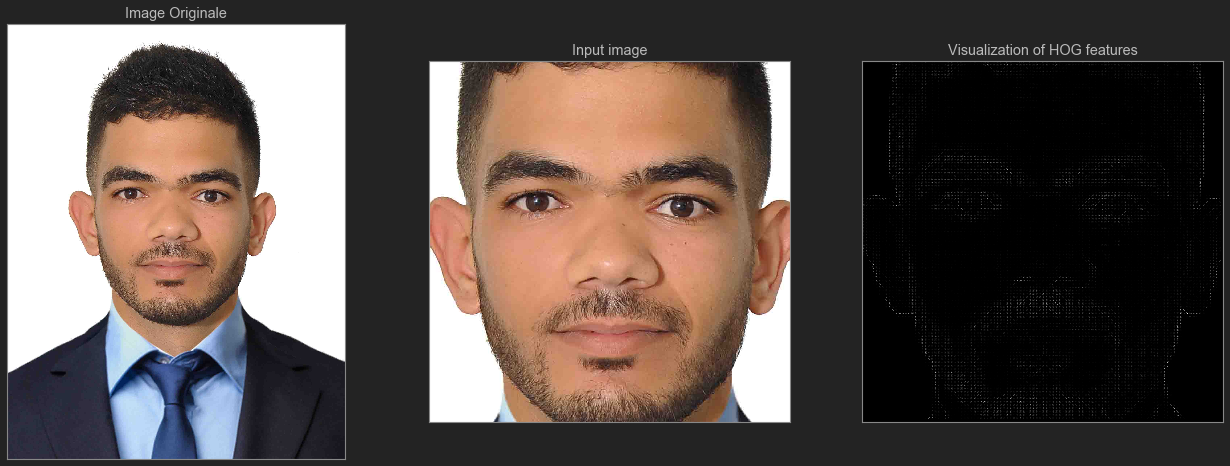

In [70]:
img_path = 'images/m.elkhou.jpg'
img = mpimg.imread(img_path)
face_seg = face_extractor(img_path, True)
hog_vec, hog_vis = get_hog(face_seg, visualize=True)
plot_img([(img, 'Image Originale'), (pltC(face_seg), 'Input image'), (hog_vis, 'Visualization of HOG features')])

In [71]:
def sliding_hog_windows(image):
    """
    Extraction de features en utilisant Hog avec la methode sliding window
    Pour chaque fenetre, on le superposer avec chaque region de notre image afin de detecter l'objet qui nous interesse.
    """
    # initialization
    image_height, image_width  = 48, 48
    window_size = 24
    window_step = 6
    hog_windows = []
    for y in range(0, image_height, window_step):
        for x in range(0, image_width, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1)))
    return hog_windows

## Define gabor filter bank with different orientations and at different scales ##

This paper proposes a facial expression recognition system based on Gabor feature using a novel local Gabor filter bank. Traditionally, a global Gabor filter bank with 5 frequencies and 8 orientations is often used to extract the Gabor feature. A lot of time will be involved to extract feature and the dimensions of such Gabor feature vector are prohibitively high. A novel local Gabor filter bank with part of frequency and orientation parameters is proposed. In order to evaluate the performance of the local Gabor filter bank, we first employed a two-stage feature compression method PCA plus LDA to select and compress the Gabor feature, then adopted minimum distance classifier to recognize facial expression. Experimental results show that the method is effective for both dimension reduction and good recognition performance in comparison with traditional entire Gabor filter bank. The best average recognition rate achieves 97.33% for JAFFE facial expression database.

link :
https://www.researchgate.net/publication/228770844_A_new_facial_expression_recognition_method_based_on_local_Gabor_filter_bank_and_PCA_plus_LDA

In [72]:
def build_filters():
	filters = []
	ksize = 9
	#define the range for theta and nu
	for theta in np.arange(0, np.pi, np.pi / 8):
		for nu in np.arange(0, 6*np.pi/4 , np.pi / 4):
			kern = cv2.getGaborKernel((ksize, ksize), 1.0, theta, nu, 0.5, 0, ktype=cv2.CV_32F)
			kern /= 1.5*kern.sum()
			filters.append(kern)
	return filters

#---------------------------------------------------
#function to convolve the image with the filters
def process(img, filters):
	accum = np.zeros_like(img)
	for kern in filters:
		fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
		np.maximum(accum, fimg, accum)
	return accum
  
def extracting_features_gabor_filter_bank(imgg):
    #instantiating the filters
    filters = build_filters()
    f = np.asarray(filters)
    #initializing the feature vector
    feat = []
    #calculating the local energy for each convolved image
    for j in range(40):
        res = process(imgg, f[j])
        temp = 0
        for p in range(imgg.shape[0]):
            for q in range(imgg.shape[1]):
                temp = temp + res[p][q]*res[p][q]
        feat.append(temp)
    #calculating the mean amplitude for each convolved image	
    for j in range(40):
        res = process(imgg, f[j])
        temp = 0
        for p in range(imgg.shape[0]):
            for q in range(imgg.shape[1]):
                temp = temp + abs(res[p][q])
            feat.append(temp)
    #feat matrix is the feature vector for the image
    #print(feat)
    return feat

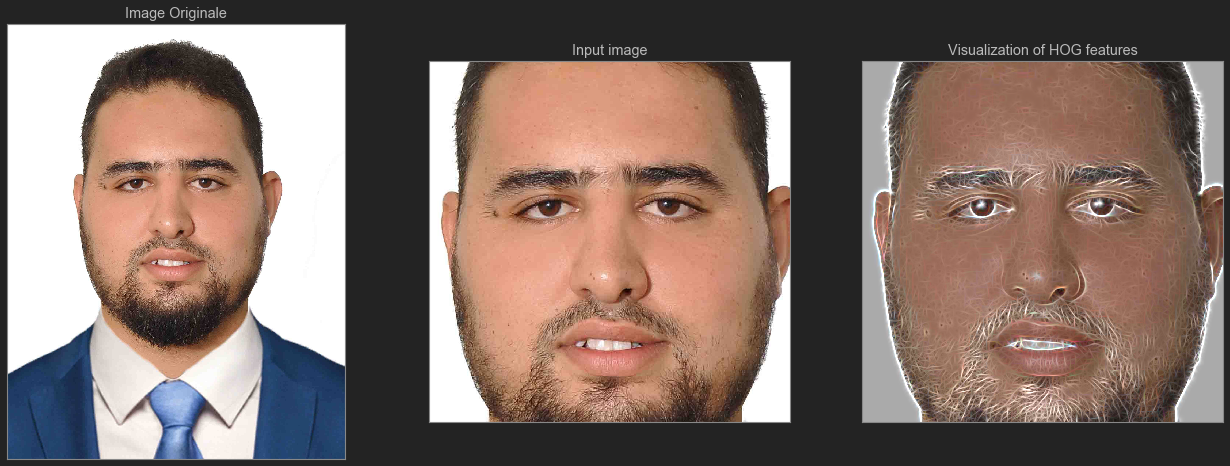

In [73]:
def build_filters1():
    filters = []
    ksize = 31
    for theta in np.arange(0, np.pi, np.pi / 16):
        kern = cv2.getGaborKernel((ksize, ksize), 4.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        kern /= 1.5*kern.sum()
        filters.append(kern)
    return filters
 
def process1(img, filters):
    accum = np.zeros_like(img)
    for kern in filters:
        fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
        np.maximum(accum, fimg, accum)
    return accum

img_path = home+'images/m_maazouz.jpg'
img = mpimg.imread(img_path)
face_seg = face_extractor(img_path, True)

filters = build_filters1()
img_gabor = process1(face_seg , filters)
plot_img([(img, 'Image Originale'), (pltC(face_seg), 'Input image'), (pltC(img_gabor), 'Visualization of HOG features')])

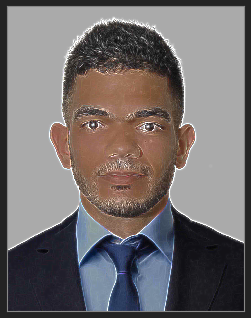

In [74]:
img_path = home+'images/m.elkhou.jpg'
img = mpimg.imread(img_path)
img = process1(img , filters)
cv2.imwrite(home+'images/mh.png', pltC(img))
plt.imshow(img)
plt.xticks([]),plt.yticks([])
# plt.savefig(home+'images/mh.png')
plt.show()

In [75]:
"""
contrast limited adaptive histogram equalization : variante de Adaptive histogram equalization (AHE)
qui permet d'améliorer le contraste d'une image
"""
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

def get_feature(img_path, face_cut=False):
    # Tous les visages sont de dimension = (96,96)
    if face_cut:
        img = face_extractor(img_path)
    else:
        img = cv2.imread(img_path, 0)
        img = cv2.resize(img, (96, 96), interpolation=cv2.INTER_AREA)

    if img is None:
        img = get_face_landmarks(img_path)
        if img is None:
            return None

    img = clahe.apply(img)
    ft_landmarks = get_landmarks(img.copy()) # len = 295
    if ft_landmarks is None:
        return None

    # ft_lbp = get_local_binary_pattern(img.copy(), 25, 8)
    
    try:
        img = cv2.resize(img, (48, 48), interpolation = cv2.INTER_AREA)#Pour reduire features de Hog
    except:
        return None

    ft_hog = get_hog(img.copy()) # len = 150
    ft_shogw = sliding_hog_windows(img.copy()) # len = 2592
    ft_gabor = extracting_features_gabor_filter_bank(img.copy()) # len= 1960
   
    global_feature = np.concatenate([ft_landmarks, ft_gabor, ft_hog, ft_shogw]).flatten() # shape = 4997
    
    return global_feature

## Helper function to load images from given directories ##

In [76]:
def indexing_db_sep(dir_path, face_cut, features, labels):
    folders = glob(str(dir_path)+os.path.sep+"*"+os.path.sep)
    for dir in tqdm(folders, desc='DB '+dir_path.split('/')[-1]):
        if os.path.isdir(dir):
            label = dir.split(os.path.sep)[-2]
            files = glob(str(dir)+os.path.sep+"*.*")
            for img_path in tqdm(files, desc=label+"\t", leave=False):
                feature = get_feature(img_path, face_cut)
                if feature is None:
                    continue
                features.append(feature)
                labels.append(label)

In [77]:
def indexing_FacesDB(dir_path, features, labels):
    emotion_dict = {'00': 'neutral', '01': 'happy', '02': 'sadness',
                    '03': 'surprise', '04': 'anger', '05': 'disgust', '06': 'fear'}
    imgs_path = glob(str(dir_path)+os.path.sep+"*" +
                     os.path.sep+'*'+os.path.sep+"*.*")
    for img_path in tqdm(imgs_path, desc='DB '+dir_path.split('/')[-1], file=sys.stdout):
        feature = get_feature(img_path, face_cut=True)
        if feature is None:
            continue
        features.append(feature)
        em = img_path.split(os.path.sep)[-1].split('-')[1].split('_')[0]
        labels.append(emotion_dict[em])

In [78]:
def indexing_KDEF(dir_path, features=[], labels=[]):
    emotion_dict = {'NE': 'neutral', 'HA': 'happy', 'SA': 'sadness',
                    'SU': 'surprise', 'AN': 'anger', 'DI': 'disgust', 'AF': 'fear'}
    imgs_path = glob(str(dir_path)+os.path.sep+"*"+os.path.sep+"*.JPG")
    for img_path in tqdm(imgs_path, desc='DB KDEF', file=sys.stdout):
        img_name = img_path.split(os.path.sep)[-1]
        if img_name[6:8] in ['FR', 'FL', 'HL','HR']:
            continue
        feature = get_feature(img_path, face_cut=True)
        if feature is None:
            continue
        features.append(feature)
        labels.append(emotion_dict[img_name[4:6]])

In [79]:
def indexing_CFD(dir_path, features=[], labels=[]):
    emotion_dict = {'N': 'neutral', 'A': 'anger', 'F': 'fear', 'C': 'happy', 'O': 'happy'}
    imgs_path = glob(str(dir_path)+os.path.sep+"*"+os.path.sep+"*.jpg")
    for img_path in tqdm(imgs_path, desc='DB CDF', file=sys.stdout):
        img_name = img_path.split(os.path.sep)[-1]
        # if img_name[6:8] in ['FR', 'FL', 'HL','HR']:
        #     continue
        feature = get_feature(img_path, face_cut=True)
        if feature is None:
            continue
        features.append(feature)
        labels.append(emotion_dict[img_name[-5]])

In [80]:
def indexing_ADEFS(dir_path, features=[], labels=[]):
    emotion_dict ={'Neutral': 'neutral', 'Joy': 'happy', 'Sad': 'sadness','Surprise': 'surprise', 
                    'Anger': 'anger', 'Disgust': 'disgust', 'Fear': 'fear'}
    imgs_path = glob(str(dir_path)+os.path.sep+"*.jpg")
    for img_path in tqdm(imgs_path, desc='DB ADEFS', file=sys.stdout):
        emotion = img_path.split(os.path.sep)[-1].split('-')[1]
        if emotion not in emotion_dict:
            continue
        feature = get_feature(img_path, face_cut=True)
        if feature is None:
            continue
        features.append(feature)
        labels.append(emotion_dict[emotion])

In [81]:
def indexing_images():
    features = []
    labels = []

    indexing_db_sep(home+"Dataset/mydataset_web", True, features, labels)       
    indexing_FacesDB(home+"Dataset/facesdb", features, labels)            # len = 252 images     
    indexing_KDEF(home+"Dataset/KDEF", features, labels)                  # len = 4899 images (1/5)    
    indexing_db_sep(home+"Dataset/CK", True, features, labels)                 
    indexing_CFD(home+"Dataset/CFD Version 2.0.3/CFD 2.0.3 Images", features, labels)
    indexing_ADEFS(home+"Dataset/ADEFS", features, labels)                # len = 216 images
        
    features = np.array(features)
    labels = np.array(labels)
    shape = features.shape
    print(labels.shape, features.shape)
    if not os.path.exists(home+'tools'):
        os.makedirs(home+'tools')
    np.save(home+'tools/f'+str(shape)+'.npy', features, allow_pickle=True)
    np.save(home+'tools/l'+str(shape)+'.npy', labels, allow_pickle=True)
    return shape

In [46]:
shape = indexing_images()

C:\Python\Python37\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in ubyte_scalars


2
3
4
2
3
4



(1078,) (1078, 4997)


## Training ML algorithm ##

## For just  CK+ Dataset  ##

***

In [44]:
def plot_bar_emotion(y, relative=True):
    width = 0.55
    length = len(y)
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
    xtemp = np.arange(len(unique))
    plt.figure(figsize=(20,10))
    plt.bar(xtemp , counts, align='center', alpha=.5,width=width,  color= 'rbmgwyc')
    plt.xticks(xtemp, unique, fontsize=16)
    plt.xlabel('emontion kinds', fontsize=18)
    plt.ylabel(ylabel_text,fontsize=18)
    plt.title('DataSet emotion distribution ( images number : '+str(length)+' )' , fontsize=22)
    plt.show()

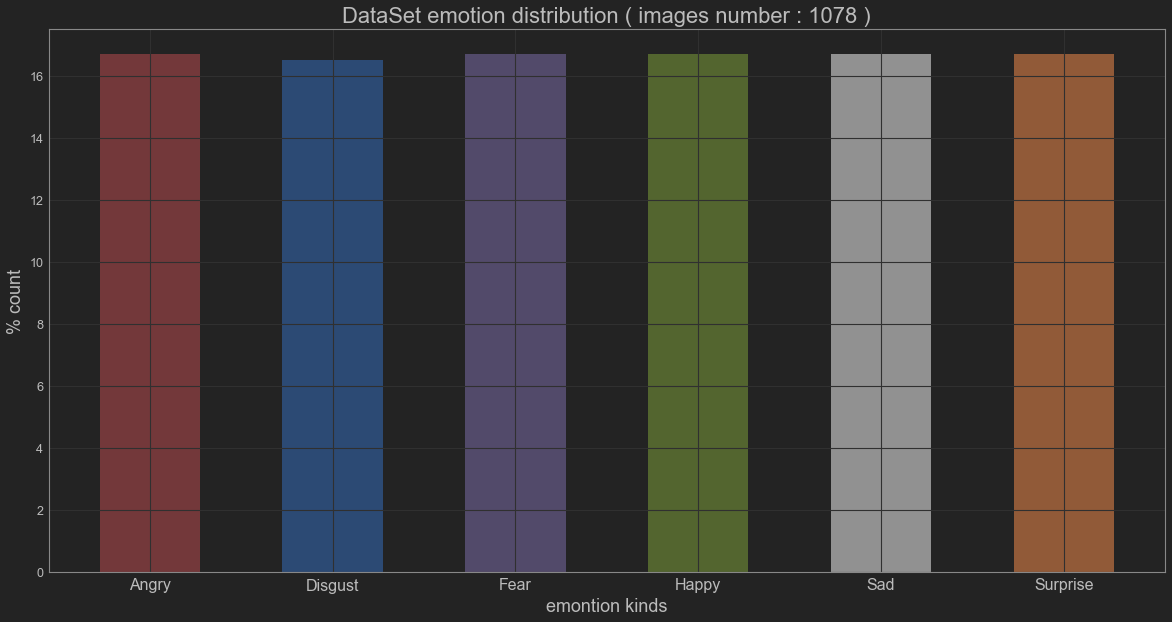

In [45]:
shape = (1078, 4997) # for just  CK+ Dataset 
features = np.load(home+'tools/f'+str(shape)+'.npy', allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape)+'.npy', allow_pickle=True)

landmarks = 295
hog = 150
hog_sw = 2592
gabor = 1960
feature_landmarks = features[:, :landmarks]
feature_gabor = features[:, landmarks:landmarks+gabor]
feature_hog = features[:, landmarks+gabor:landmarks+gabor+hog]
feature_hog_sw = features[:, landmarks+gabor+hog:]

plot_bar_emotion(labels)

In [46]:
def kfold(features, labels, ml_algo, applied_FE = False, k = 5):
    
    if applied_FE:
        scaler = StandardScaler()
        pca = PCA(.95)
        model = make_pipeline(scaler, pca, ml_algo)
    else:
        model = ml_algo

    scores = []
    f1_scores = []
    cv = KFold(n_splits=k, random_state=42, shuffle=True)
    for train_index, test_index in tqdm(cv.split(labels), total=cv.n_splits, desc='K-Fold'):
        X_train, X_test, y_train, y_test = features[train_index], features[test_index], labels[train_index], labels[test_index]

        model.fit(X_train, y_train)
        y_pred=model.predict(X_test)

        scores.append(model.score(X_test, y_test))
        f1_scores.append(f1_score(y_test, y_pred,average='weighted'))
    print("[INFO]\tAccuracy = ",int(np.mean(scores)*100),'%')
    print("[INFO]\f1_score = ",int(np.mean(f1_scores)*100),'%')
    return int(np.mean(scores)*100), int(np.mean(f1_scores)*100)

In [47]:
def best_parmetres(features, labels, ml_algo, param_grid):
    scaler = StandardScaler()
    pca = PCA(.95)

    model = make_pipeline(scaler, pca, ml_algo)
    
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    grid = GridSearchCV(model, param_grid, scoring = ['f1','accuracy'], cv = cv, verbose = 10,n_jobs = -1)
    grid.fit(features, labels)
    print("Best parameter (CV score=%0.3f):" % grid.best_score_, "\n", grid.best_params_)
    
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)
    ml_algo
    y_pred = model.predict(X_test)
    
    return grid.best_score_, f1_score

## Putting it all together
### Selecting dimensionality reduction with Pipeline and GridSearchCV

***

Idea from :
* https://stats.stackexchange.com/questions/364245/sklearn-gridsearchcv-roc-auc-score-better-with-evaluating-against-accuracy-th
* https://scikit-learn.org/stable/auto_examples/model_selection/plot_multi_metric_evaluation.html

In [ ]:
def GridSearch(features, labels):
    
    pipe_params = {
        'pre_processing': [StandardScaler(), MinMaxScaler(), None],
        'pca': [PCA(n_components=0.95), PCA(n_components=0.85), None],
    }

    param_grid = [
        {
            **pipe_params,
            'ml_algo' : [SVC(kernel='linear', tol=1e-3)],
            'ml_algo__C': [1, 1e3, 5e3, 1e4, 5e4, 1e5, 2e5]
        },
        {
            **pipe_params,
            'ml_algo' : [SVC(kernel='rbf', class_weight='balanced')],
            'ml_algo__C': [1, 1e3, 5e3, 1e4, 5e4, 1e5, 2e5],
            'ml_algo__gamma': [1, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 2e-5]
        },
        {
            **pipe_params,
            'ml_algo' : [LogisticRegression()],
            'ml_algo__C': [0.01, 0.1, 1, 10, 100],
            'ml_algo__penalty': ['l1', 'l2']
        },
        {
            **pipe_params,
            'ml_algo' : [ KNeighborsClassifier()],
            'ml_algo__n_neighbors': list(range(1,20,2))+list(range(20,100,5))
        },
        {
            **pipe_params,
            'ml_algo' : [GaussianNB()],
        }
    ]  
    
    pipe = Pipeline([
        ('pre_processing', None),
        ('pca', None),
        ('ml_algo', None)
    ])

    cv = KFold(n_splits=2, random_state=42, shuffle=True)
    
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring = ['f1_micro','accuracy'], refit='accuracy', cv = cv, verbose = 10, n_jobs = -1)
    grid.fit(features, labels)
    print("Best parameter (CV score=%0.3f):" % grid.best_score_, "\n", grid.best_params_)
        
    return grid.best_score_, grid.cv_results_

In [48]:
def GridSearch(features, labels):
    
    pipe_params = {
        'pre_processing': [StandardScaler(), MinMaxScaler(), None],
        'pca': [PCA(n_components=0.95), PCA(n_components=0.85), None],
    }

    param_grid = [
        {
            **pipe_params,
            'ml_algo' : [SVC(kernel='linear', tol=1e-3)],
            'ml_algo__C': [1,10] #[1, 1e3, 5e3, 1e4, 5e4, 1e5, 2e5]
        },
        {
            **pipe_params,
            'ml_algo' : [SVC(kernel='rbf', class_weight='balanced')],
            'ml_algo__C': [1,10],#[1, 1e3, 5e3, 1e4, 5e4, 1e5, 2e5],
            'ml_algo__gamma': [0.00001, 0.001]#[1, 1e-3, 5e-3, 1e-4, 5e-4, 1e-5, 2e-5]
        },
        {
            **pipe_params,
            'ml_algo' : [LogisticRegression()],
            'ml_algo__C': [0.01, 0.1, 1, 10, 100],
#             'ml_algo__penalty': ['l1', 'l2']
        },
        {
            **pipe_params,
            'ml_algo' : [ KNeighborsClassifier()],
            'ml_algo__n_neighbors': [1,5,10]#list(range(1,20,2))+list(range(20,100,5))
        },
        {
            **pipe_params,
            'ml_algo' : [GaussianNB()],
        }
    ]  
    
    pipe = Pipeline([
        ('pre_processing', None),
        ('pca', None),
        ('ml_algo', None)
    ])

    cv = KFold(n_splits=2, random_state=42, shuffle=True)
    
    grid = GridSearchCV(pipe, param_grid=param_grid, scoring = ['f1_micro','accuracy'], refit='accuracy', cv = cv, verbose = 10, n_jobs = -1)
    grid.fit(features, labels)
    print("Best parameter (CV score=%0.3f):" % grid.best_score_, "\n", grid.best_params_)
        
    return grid.best_score_, grid.cv_results_

In [49]:
best_score, cv_results = GridSearch(feature_landmarks, labels)

Fitting 2 folds for each of 135 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  53 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  77 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 105 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:  1

Best parameter (CV score=0.917): 
 {'ml_algo': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform'), 'ml_algo__n_neighbors': 1, 'pca': None, 'pre_processing': MinMaxScaler(copy=True, feature_range=(0, 1))}


[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed:  2.1min finished


In [28]:
df = pd.DataFrame(cv_results)
df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml_algo,param_ml_algo__C,param_pca,param_pre_processing,param_ml_algo__gamma,param_ml_algo__n_neighbors,...,split0_test_f1_micro,split1_test_f1_micro,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,split0_test_accuracy,split1_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy
0,0.347088,0.018061,0.033682,5.371332e-03,"SVC(C=1.0, cache_size=200, class_weight=None, ...",1,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with...",NaN,NaN,...,0.699443,0.706865,0.703154,0.003711,30,0.699443,0.706865,0.703154,0.003711,30
1,0.132781,0.008786,0.039541,4.393697e-03,"SVC(C=1.0, cache_size=200, class_weight=None, ...",1,"PCA(copy=True, iterated_power='auto', n_compon...","MinMaxScaler(copy=True, feature_range=(0, 1))",NaN,NaN,...,0.736549,0.745826,0.741187,0.004638,16,0.736549,0.745826,0.741187,0.004638,16
2,8.849991,3.352248,0.017574,2.384186e-07,"SVC(C=1.0, cache_size=200, class_weight=None, ...",1,"PCA(copy=True, iterated_power='auto', n_compon...",None,NaN,NaN,...,0.473098,0.450835,0.461967,0.011132,100,0.473098,0.450835,0.461967,0.011132,100
3,0.386628,0.054676,0.031730,6.345391e-03,"SVC(C=1.0, cache_size=200, class_weight=None, ...",1,"PCA(copy=True, iterated_power='auto', n_compon...","StandardScaler(copy=True, with_mean=True, with...",NaN,NaN,...,0.662338,0.656772,0.659555,0.002783,52,0.662338,0.656772,0.659555,0.002783,52
4,0.102027,0.005370,0.025873,2.440929e-03,"SVC(C=1.0, cache_size=200, class_weight=None, ...",1,"PCA(copy=True, iterated_power='auto', n_compon...","MinMaxScaler(copy=True, feature_range=(0, 1))",NaN,NaN,...,0.651206,0.658627,0.654917,0.003711,57,0.651206,0.658627,0.654917,0.003711,57
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130,0.101540,0.001954,0.016598,2.145767e-06,"GaussianNB(priors=None, var_smoothing=1e-09)",NaN,"PCA(copy=True, iterated_power='auto', n_compon...","MinMaxScaler(copy=True, feature_range=(0, 1))",NaN,NaN,...,0.586271,0.576994,0.581633,0.004638,83,0.586271,0.576994,0.581633,0.004638,83
131,0.101050,0.001464,0.011228,4.878044e-04,"GaussianNB(priors=None, var_smoothing=1e-09)",NaN,"PCA(copy=True, iterated_power='auto', n_compon...",None,NaN,NaN,...,0.252319,0.246753,0.249536,0.002783,118,0.252319,0.246753,0.249536,0.002783,118
132,0.036614,0.010252,0.074689,4.875660e-04,"GaussianNB(priors=None, var_smoothing=1e-09)",NaN,None,"StandardScaler(copy=True, with_mean=True, with...",NaN,NaN,...,0.688312,0.625232,0.656772,0.031540,53,0.688312,0.625232,0.656772,0.031540,53
133,0.027339,0.000978,0.079083,9.752512e-04,"GaussianNB(priors=None, var_smoothing=1e-09)",NaN,None,"MinMaxScaler(copy=True, feature_range=(0, 1))",NaN,NaN,...,0.688312,0.625232,0.656772,0.031540,53,0.688312,0.625232,0.656772,0.031540,53


In [30]:
# df['param_ml_algo'] = df['param_ml_algo'].apply(lambda x: x.split('(')[0])
# df

In [31]:
scores = df.loc[df.groupby(['param_ml_algo'], sort=False)['mean_test_accuracy'].idxmax()]   
scores['ml_algo']=['SVM_rbf', 'SVM_linear', 'LR', 'KNN', 'GNB'] 
scores
# scores = df.groupby(['param_ml_algo'], sort=False)
# scores.plot()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_ml_algo,param_ml_algo__C,param_pca,param_pre_processing,param_ml_algo__gamma,param_ml_algo__n_neighbors,...,split1_test_f1_micro,mean_test_f1_micro,std_test_f1_micro,rank_test_f1_micro,split0_test_accuracy,split1_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,ml_algo
7,0.086405,0.004394,0.139128,4.892349e-04,"SVC(C=1.0, cache_size=200, class_weight=None, ...",1,None,"MinMaxScaler(copy=True, feature_range=(0, 1))",NaN,NaN,...,0.769944,0.767161,0.002783,12,0.764378,0.769944,0.767161,0.002783,12,SVM_rbf
53,0.218699,0.001952,0.228951,3.417492e-03,"SVC(C=1.0, cache_size=200, class_weight='balan...",10,None,None,0.001,NaN,...,0.847866,0.851577,0.003711,7,0.855288,0.847866,0.851577,0.003711,7,SVM_linear
69,0.380771,0.011716,0.009764,3.576279e-07,"LogisticRegression(C=1.0, class_weight=None, d...",0.1,None,"StandardScaler(copy=True, with_mean=True, with...",NaN,NaN,...,0.723562,0.723562,0.000000,20,0.723562,0.723562,0.723562,0.000000,20,LR
106,0.027338,0.000978,0.543329,8.297801e-03,"KNeighborsClassifier(algorithm='auto', leaf_si...",NaN,None,"MinMaxScaler(copy=True, feature_range=(0, 1))",NaN,1,...,0.925788,0.917440,0.008349,1,0.909091,0.925788,0.917440,0.008349,1,KNN
127,0.107397,0.002929,0.022455,3.905535e-03,"GaussianNB(priors=None, var_smoothing=1e-09)",NaN,"PCA(copy=True, iterated_power='auto', n_compon...","MinMaxScaler(copy=True, feature_range=(0, 1))",NaN,NaN,...,0.673469,0.682746,0.009276,42,0.692022,0.673469,0.682746,0.009276,42,GNB


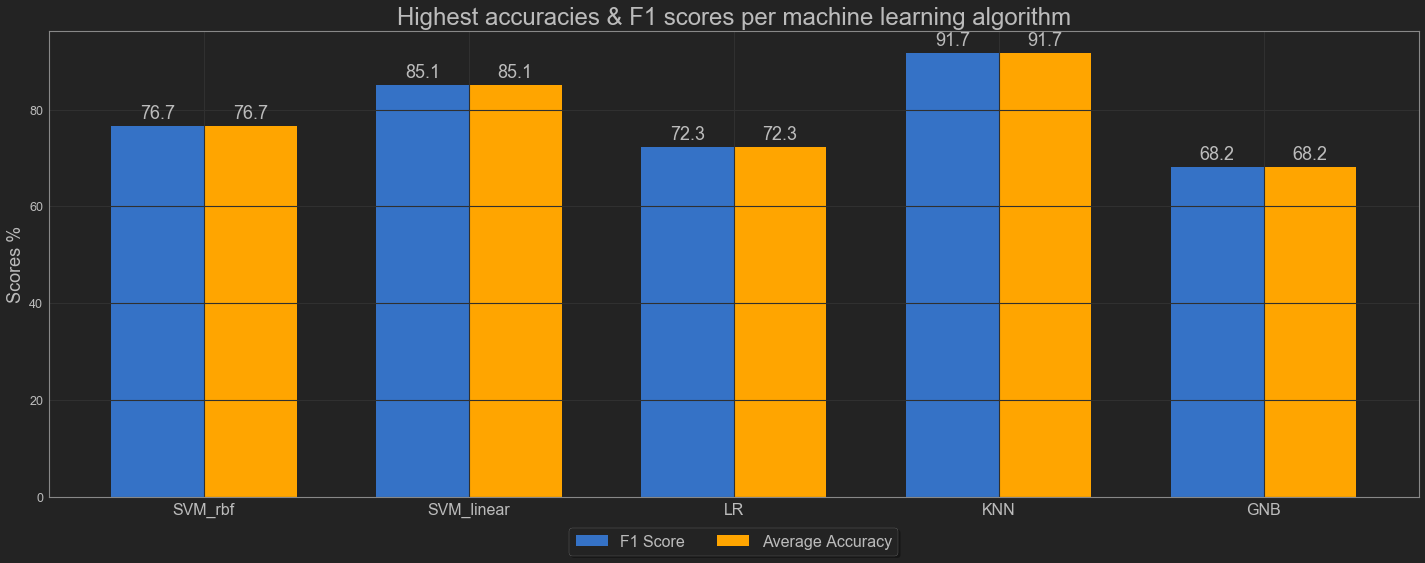

In [35]:
def plt_scores(labels, accuracy, f1_Score):
    x = np.arange(len(labels))  # the label locations
    width = 0.35  # the width of the bars
    fig, ax = plt.subplots(figsize=(20,8))
    rects1 = ax.bar(x - width/2, accuracy, width, label='F1 Score', color='b')
    rects2 = ax.bar(x + width/2, f1_Score, width, label='Average Accuracy', color='orange')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('Scores %' , fontsize=18)
    ax.set_title('Highest accuracies & F1 scores per machine learning algorithm' , fontsize=24)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=16)

    ax.legend(fontsize=16, loc='upper center', bbox_to_anchor=(0.5, -0.05),
              fancybox=True, shadow=True, ncol=2)
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=18)
    autolabel(rects1)
    autolabel(rects2)
    fig.tight_layout()
    plt.show()
    
# all ML algorithmes
accuracy = (scores['mean_test_accuracy']*1e3).astype('int64')/10
f1_Score = (scores['mean_test_f1_micro']*1e3).astype('int64')/10
labels = algorithm = ['SVM_rbf', 'SVM_linear', 'LR', 'KNN', 'GNB'] 
plt_scores(labels, accuracy, f1_Score)

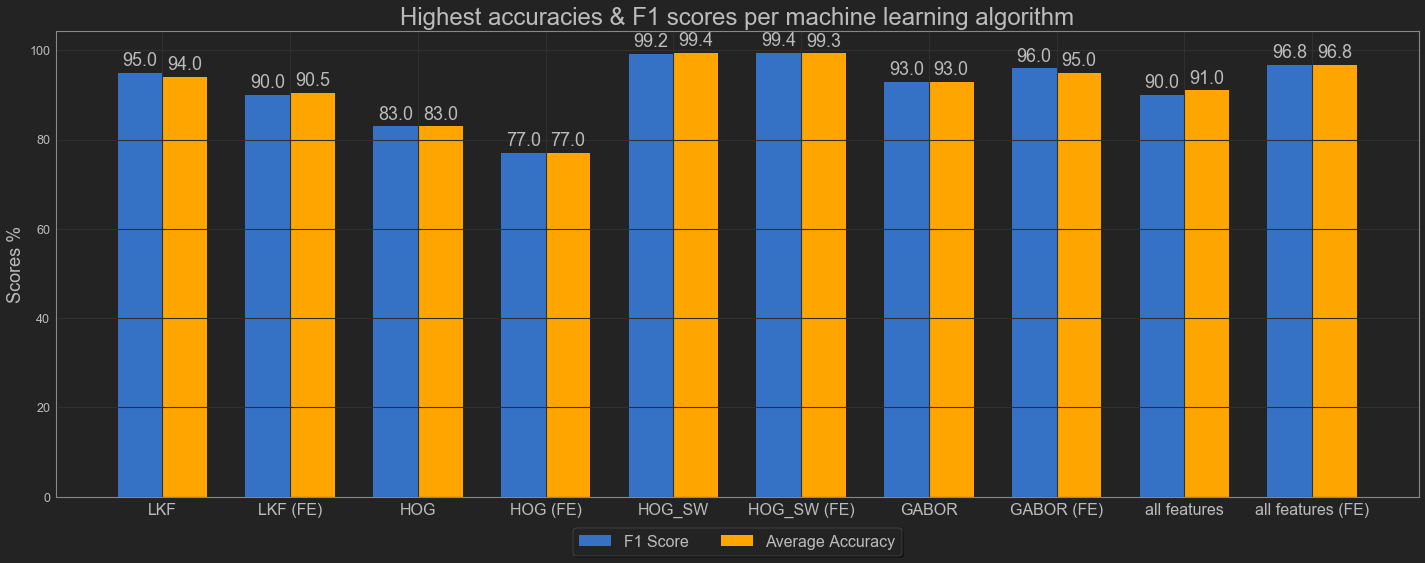

In [52]:
# CK+ dataset
accuracy = [95, 90,   83, 77, 99.2, 99.4, 93, 96, 90, 96.8]
f1_Score = [94, 90.5, 83, 77, 99.4, 99.3, 93, 95, 91, 96.8]
labels = ['LKF', 'LKF (FE)','HOG','HOG (FE)','HOG_SW','HOG_SW (FE)','GABOR','GABOR (FE)', 
            'all features', 'all features (FE)']

# all-dataset
# Score = [68.1, 72.2, 68.7, 61.5, 83.7, 75.4, 72.8, 70.9, 80.8, 83.4]
# F1_Score = [68.1, 72.1, 68.6, 61.4, 83.5, 75.3, 72.6, 70.7, 79.9, 83.2]
# features = ['LKF', 'LKF (FE)','HOG','HOG (FE)','HOG_SW','HOG_SW (FE)','GABOR','GABOR (FE)', 
#             'all features', 'all features (FE)']
plt_scores(labels, accuracy, f1_Score)

## For  ALL Dataset ##

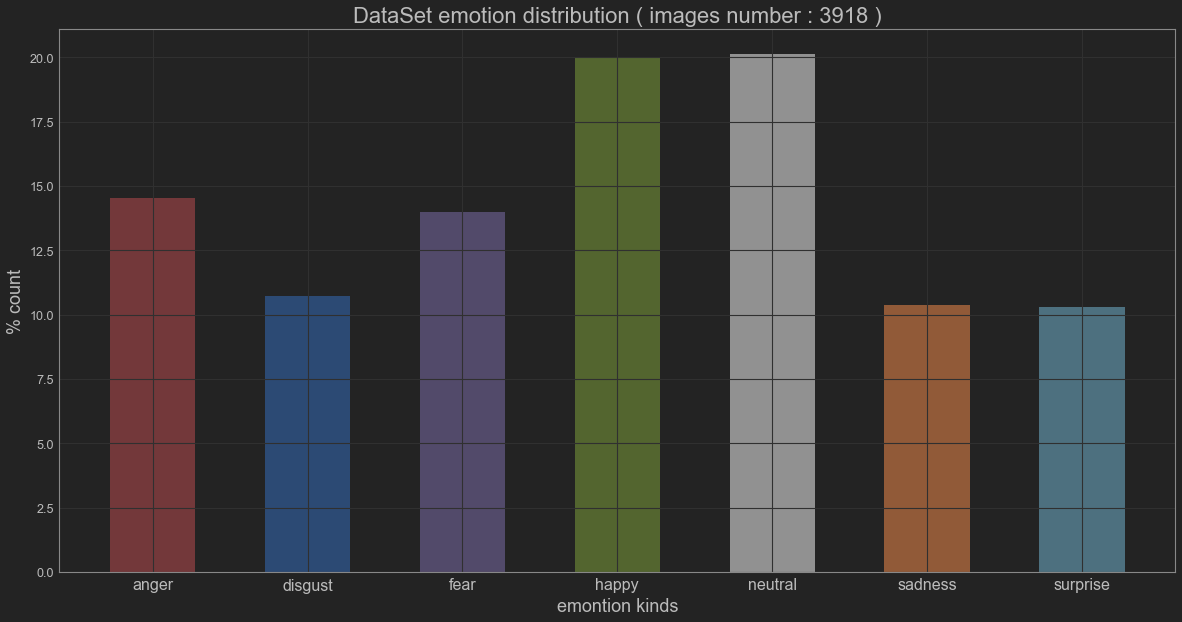

In [17]:
shape = (3918, 4997) # for just  ALL Dataset 
features = np.load(home+'tools/f'+str(shape)+'.npy', allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape)+'.npy', allow_pickle=True)

landmarks = 295
hog = 150
hog_sw = 2592
gabor = 1960
feature_landmarks = features[:, :landmarks]
feature_gabor = features[:, landmarks:landmarks+gabor]
feature_hog = features[:, landmarks+gabor:landmarks+gabor+hog]
feature_hog_sw = features[:, landmarks+gabor+hog:]

plot_bar_emotion(labels)

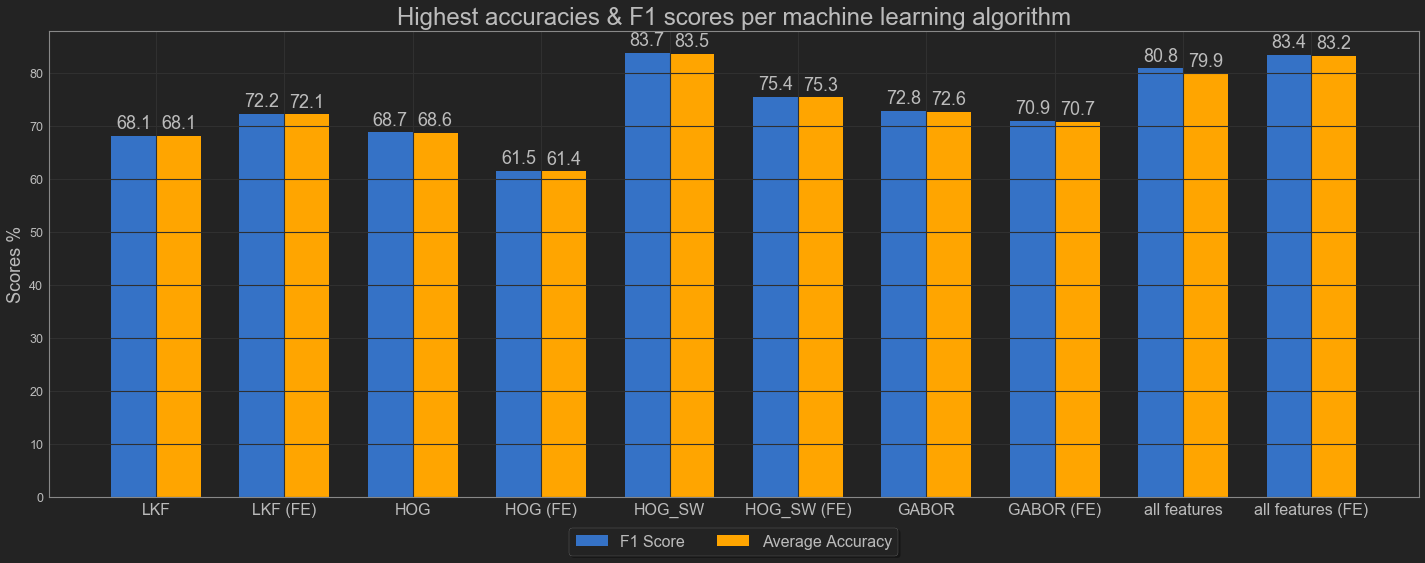

In [53]:
# all-dataset
accuracy = [68.1, 72.2, 68.7, 61.5, 83.7, 75.4, 72.8, 70.9, 80.8, 83.4]
f1_Score = [68.1, 72.1, 68.6, 61.4, 83.5, 75.3, 72.6, 70.7, 79.9, 83.2]
labels = ['LKF', 'LKF (FE)','HOG','HOG (FE)','HOG_SW','HOG_SW (FE)','GABOR','GABOR (FE)', 
            'all features', 'all features (FE)']
plt_scores(labels, accuracy, f1_Score)

## Testing Trained Model ( Evalute Model Performance ) ##

In [23]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plot_confusion_matrix(test_y, predict_y, labels):
    C = confusion_matrix(test_y, predict_y)  
    plt.figure(figsize=(16,8))
    sns.heatmap(C, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.title('confusion matrix')
    plt.xlabel('Predicted Class', c='b')
    plt.ylabel('Original Class', c='b')
    plt.show()

    # divid each element of the confusion matrix with the sum of elements in that column
    C1  =(((C.T)/(C.sum(axis=1))).T)
    plt.figure(figsize=(16,8))
    sns.heatmap(C1, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.title('Divid each element of the confusion matrix with the sum of elements in that column')
    plt.xlabel('Predicted Class', c='b')
    plt.ylabel('Original Class', c='b')
    plt.show()

    # divid each element of the confusion matrix with the sum of elements in that row
    C2 =(C/C.sum(axis=0))
    plt.figure(figsize=(16,8))
    sns.heatmap(C2, annot=True, cmap="YlGnBu", fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.title('Divid each element of the confusion matrix with the sum of elements in that row')
    plt.xlabel('Predicted Class', c='b')
    plt.ylabel('Original Class', c='b')
    plt.show()


## Plot confusion matrix 
Code from :
* from https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels

In [54]:
def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax)
    #plt.savefig(filename)
    plt.show()

C:\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Python\Python37\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Accuracy: 88.889%
F1 Score:  0.8933279011040639
Precision Score:  0.8935738208056287
Recall Score:  0.8960833519540269


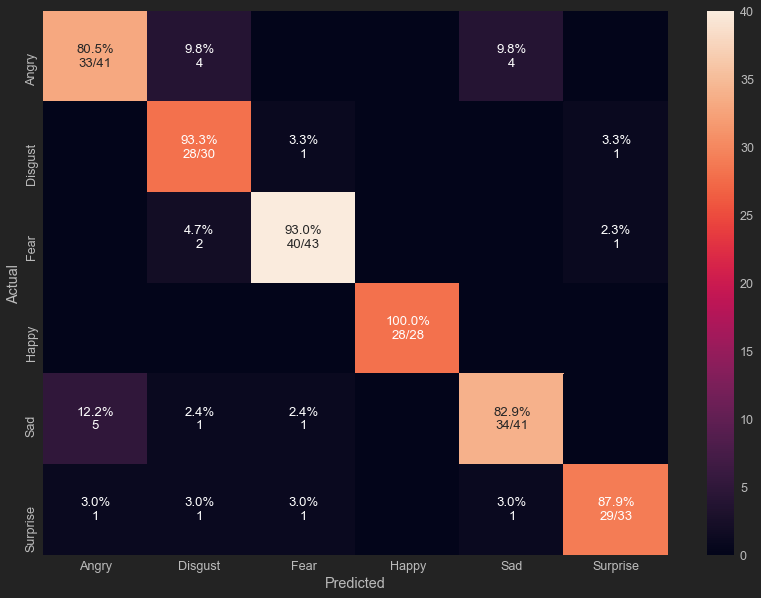

In [56]:
features = np.load(home+'tools/f'+str(shape)+'.npy', allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape)+'.npy', allow_pickle=True)

from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
test_size = 0.2
seed = 7
X_train, X_test, y_train, y_test = model_selection.train_test_split(features, labels, test_size=test_size, shuffle=True,random_state=seed)

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

model = LogisticRegression()
model.fit(X_train, y_train)
result = model.score(X_test, y_test)
print("Accuracy: %.3f%%" % (result*100.0))
y_pred = model.predict(X_test)
print("F1 Score: ", f1_score(y_test, y_pred, average="macro"))
print("Precision Score: ", precision_score(y_test, y_pred, average="macro"))
print("Recall Score: ", recall_score(y_test, y_pred, average="macro")) 

cm_analysis(y_test, y_pred, model.classes_, ymap=None, figsize=(14,10))

In [0]:
shape = (2585, 4997)
features = np.load(home+'tools/f'+str(shape)+'.npy', allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape)+'.npy', allow_pickle=True)

# from sklearn.cross_validation import train_test_split
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)

In [0]:
features =np.load(home+'tools/f'+str(shape)+'.npy',allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape)+'.npy',allow_pickle=True)
scores = []
for _ in tqdm(range(20)):
    (trainFeat, testFeat, trainLabels, testLabels) = train_test_split(
                features, labels, test_size=0.2, random_state=random.seed())
    model = SVC(kernel='linear', probability=True, tol=1e-3)
    
#     trainFeat = FE.normalization_train(trainFeat, trainLabels)
#     testFeat = FE.normalization_test(testFeat)
    
    model.fit(trainFeat,trainLabels)
    score = model.score(testFeat,testLabels)*100
    scores.append(score)
print("[INFO]\tAccuracy = ",int(np.mean(scores)),'%')



[INFO]	Accuracy =  80 %


In [0]:
from sklearn.model_selection import KFold, ShuffleSplit

scores = []
model = SVC(kernel='linear', probability=True, tol=1e-3)
features = np.load(home+'tools/f'+str(shape)+'.npy',allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape)+'.npy',allow_pickle=True)
cv = KFold(n_splits=5, random_state=42, shuffle=True)
for train_index, test_index in tqdm(cv.split(labels), total=cv.n_splits, desc='K-Fold'):
    X_train, X_test, y_train, y_test = features[train_index], features[test_index], labels[train_index], labels[test_index]
    
    X_train = FE.normalization_train(X_train, y_train)
    X_test = FE.normalization_test(X_test)
    
    model.fit(X_train, y_train)
    scores.append(model.score(X_test, y_test))
print("[INFO]\tAccuracy =  = ",int(np.mean(scores)*100),'%')


[INFO]	Accuracy =  =  65 %


## Testing trained Model ##

In [11]:
# from https://kapernikov.com/tutorial-image-classification-with-scikit-learn/
def plot_bar(y, loc='left', relative=True):
    width = 0.35
    if loc == 'left':
        n = -0.5
    elif loc == 'right':
        n = 0.5
 
    # calculate counts per type and sort, to ensure their order
    unique, counts = np.unique(y, return_counts=True)
    sorted_index = np.argsort(unique)
    unique = unique[sorted_index]
 
    if relative:
        # plot as a percentage
        counts = 100*counts[sorted_index]/len(y)
        ylabel_text = '% count'
    else:
        # plot counts
        counts = counts[sorted_index]
        ylabel_text = 'count'
 
    xtemp = np.arange(len(unique))
 
    plt.bar(xtemp + n*width, counts, align='center', alpha=.7, width=width)
    plt.xticks(xtemp, unique)
    plt.xlabel('Emotion kind', fontsize=18)
    plt.ylabel(ylabel_text)

def plot_statistique(y_train, y_test):
    plt.suptitle('All DataSet emotion distribution ( images number : 3918 )', fontsize=22)
    plot_bar(y_train, loc='left')
    plot_bar(y_test, loc='right')
    plt.legend([
        'train ({0} images)'.format(len(y_train), fontsize=16),
        'test ({0} images)'.format(len(y_test), fontsize=16)
    ]);

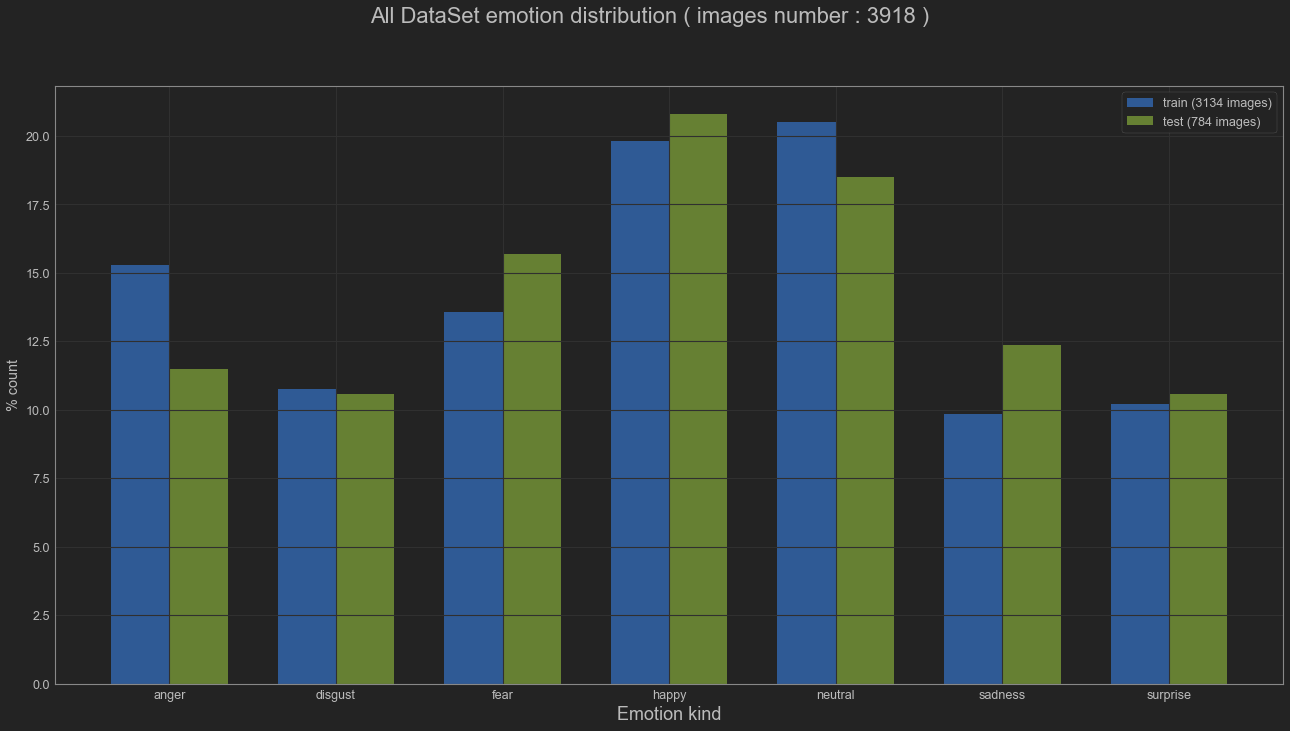

In [12]:
shape = (3918, 4997)
features = np.load(home+'tools/f'+str(shape)+'.npy', allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape)+'.npy', allow_pickle=True)

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, shuffle=True, random_state=42)
plt.figure(figsize=(22,11))
plot_statistique(y_train, y_test)


Accuracy =  84.18367346938776 %


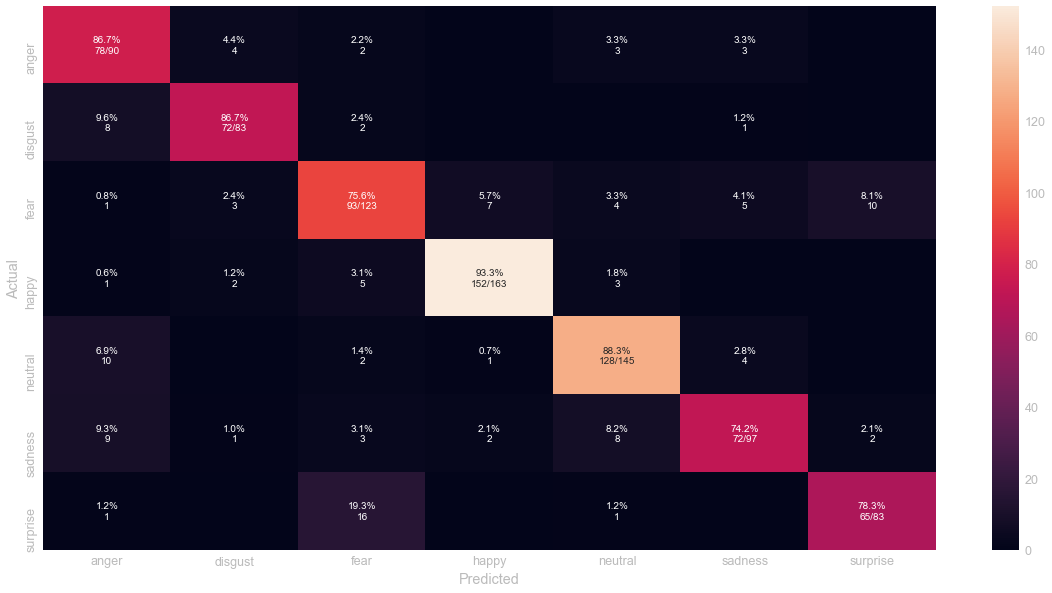

In [57]:
scaler = StandardScaler()
# pca = PCA(n_components=260)
# svc = SVC(kernel='rbf', class_weight='balanced', C = 100000.0, gamma = 0.0001, probability=True) # score=86
pca = PCA(n_components=713)
svc = SVC(kernel='linear', class_weight='balanced', C=633,
          tol=1e-3, probability=True)  # score = 84%
model = make_pipeline(scaler, pca, svc)
model.fit(X_train, y_train)
print("Accuracy = ", model.score(X_test, y_test)*100, '%' )
y_pred=model.predict(X_test)
# clf_report = classification_report(y_test, y_pred, target_names=model.classes_, output_dict=True)
# plt.figure(figsize=(20,10))
# sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)
cm_analysis(y_test, y_pred, model.classes_, ymap = None, figsize = (20,10))

## Model Deployment ##

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline, Pipeline
scaler = StandardScaler()
# pca = PCA(n_components=260)
# svc = SVC(kernel='rbf', class_weight='balanced', C = 100000.0, gamma = 0.0001, probability=True) # score=86
pca = PCA(n_components=713)
svc = SVC(kernel='linear', class_weight='balanced', C = 633, tol=1e-3, probability=True) # score = 84%

model = make_pipeline(scaler, pca, svc)
shape = (3918, 4997)
features =np.load(home+'tools/f'+str(shape)+'.npy', allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape)+'.npy', allow_pickle=True)
model.fit(features, labels)
joblib.dump(model, home+'tools/model.sav')

['D:/WISD/S3/Image_Mining/Facial-Expression-Detection/tools/model.sav']

In [82]:
loaded_model = joblib.load(home+'tools/model.sav')

### Test Final

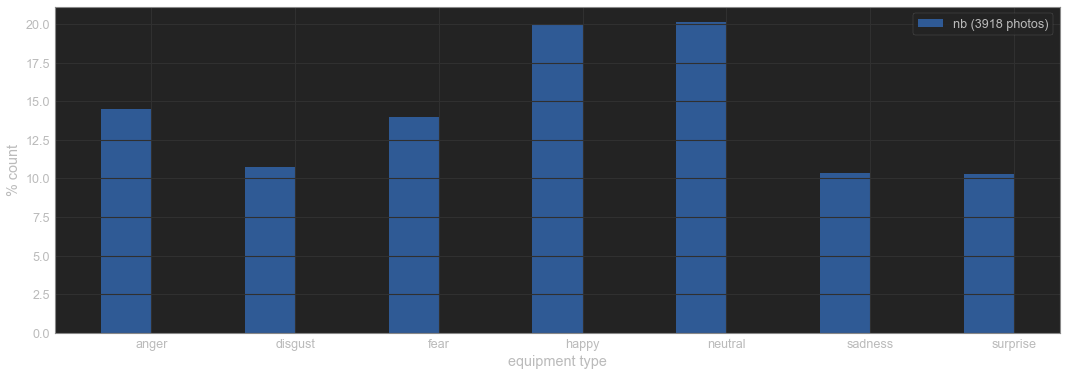

0.8380102040816326
0.8354591836734694
0.8469387755102041
0.8416347381864623
0.8492975734355045

[INFO]	Accuracy =  84.22680949774546 %


In [47]:
def kfold(loaded_model):
    # shape = (3788, 4997)
    shape = (3918, 4997)
    features =np.load(home+'tools/f'+str(shape)+'.npy', allow_pickle=True)
    labels = np.load(home+'tools/l'+str(shape)+'.npy', allow_pickle=True)

    plot_bar(labels)
    plt.legend(['nb ({0} photos)'.format(len(labels))])
    plt.show()
    model = loaded_model
    scores = []
    cv = KFold(n_splits=5, random_state=42, shuffle=True)
    for train_index, test_index in tqdm(cv.split(labels), total=cv.n_splits, desc='K-Fold'):
        X_train, X_test, y_train, y_test = features[train_index], features[test_index], labels[train_index], labels[test_index]
        
        model.fit(X_train, y_train)
        print(model.score(X_test, y_test))
        scores.append(model.score(X_test, y_test))
    print("[INFO]\tAccuracy = ", np.mean(scores)*100,'%')

kfold(loaded_model)

In [83]:
def plot_emotion_analysis(probas, emotions):
#     emotions = ('anger' 'disgust' 'fear' 'happy' 'neutral' 'sadness' 'surprise')
    y_pos = np.arange(len(emotions))
    plt.bar(y_pos, probas*100, align='center', alpha=0.5, color= 'rbmgwyc')
    plt.xticks(y_pos, emotions, fontsize=16)
#     ax.set_xticklabels(labels, fontsize=16)
    plt.ylabel('percentage')
    plt.title('emotion')
    plt.show()

2
3
4


C:\Python\Python37\lib\site-packages\ipykernel_launcher.py:33: RuntimeWarning: overflow encountered in ubyte_scalars


sadness
['anger' 'disgust' 'fear' 'happy' 'neutral' 'sadness' 'surprise']
[0.04144157 0.00351754 0.30546272 0.04752618 0.0262812  0.51880343
 0.05696737]


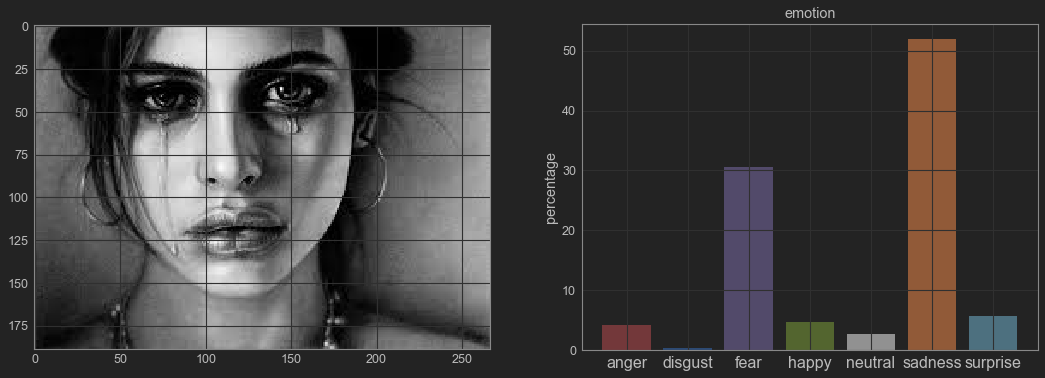

In [85]:
# img_path = home+'Dataset/mydataset_web/happy/1 (2).jfif'
# img_path = home+'Dataset/mydataset_web/happy/1 (3).jfif'
# img_path = home+'Dataset/mydataset_web/happy/1 (79).jpg'
# img_path = home+'Dataset/mydataset_web/surprise/1 (15).jpg'
img_path = home+'Dataset/mydataset_web/sadness/1 (1).jfif'
# img_path = home+'images/14.jpg'
# img_path = 'Dataset/mydataset/happy/otman.jpg'
# img_path = 'Dataset/mydataset/happy/nada.jpg'
# img_path = 'Dataset/mydataset/happy/imad.jpeg'
# img_path = 'Dataset/mydataset/happy/akka.jpeg'
# img_path = 'Dataset/mydataset/happy/hamza.jpg'
# img_path = 'Dataset/mydataset/happy/badr.jpg'
# img_path = 'D:\Mohamed EL KHOU\MAAZOUZ/m_maazouz.jpg'
# img_path = 'D:\Mohamed EL KHOU\Mohammed_EL_KHOU/m.elkhou.jpg'
# img_path = 'D:\Mohamed EL KHOU/Mohammed.png'
# img_path = 'Dataset/mydataset_web/sadness/1 (12).jpg'
# img_path = "C:/Users/mhmh2/Downloads/DSC_4857.jpg"
# img_path = 'D:\WISD\S3\Image_Mining\Facial-Expression-Detection\Dataset\mydataset_web\anger/1 (13).jpg'
# img_path = 'D:\WISD\S3\Image_Mining\Facial-Expression-Detection\Dataset\mydataset\anger/maazouz.jpg'
# img_path = 'D:/WISD\S3/Image_Mining/Facial-Expression-Detection/Dataset/mydataset/anger/mh.jpg'
f = get_feature(img_path, True)
if f is None :
    print(None)
else:
    print(loaded_model.predict([f])[0])
    print(loaded_model.classes_)
    print(loaded_model.predict_proba([f])[0])
    
#     draw_face_landmarks(img_path)
    plt.rcParams['figure.figsize'] = [18,6]
    plt.subplot(1,2,1)
    plt.imshow(plt.imread(img_path))
    plt.subplot(1,2,2)
    plot_emotion_analysis(loaded_model.predict_proba([f])[0], loaded_model.classes_)
    

## Accuracy =  50.595238095238095 %


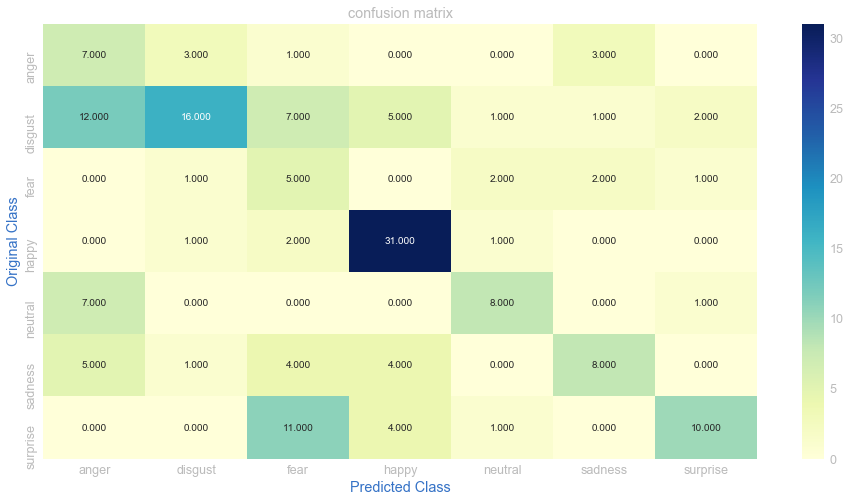

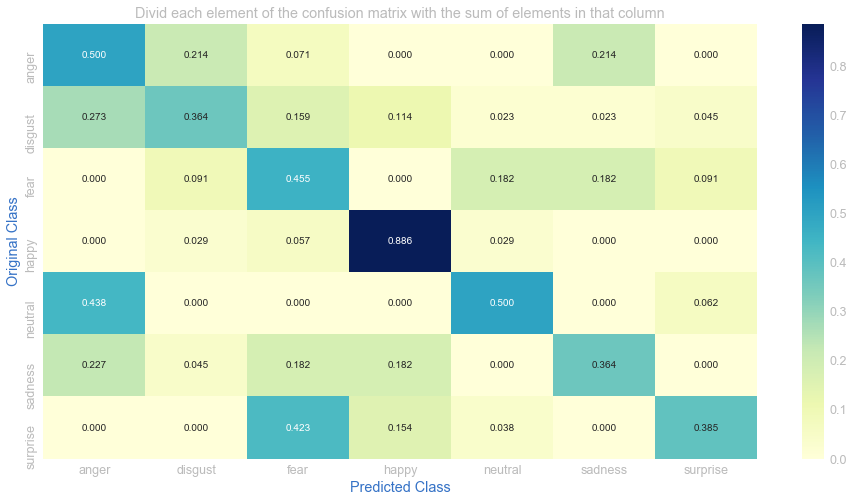

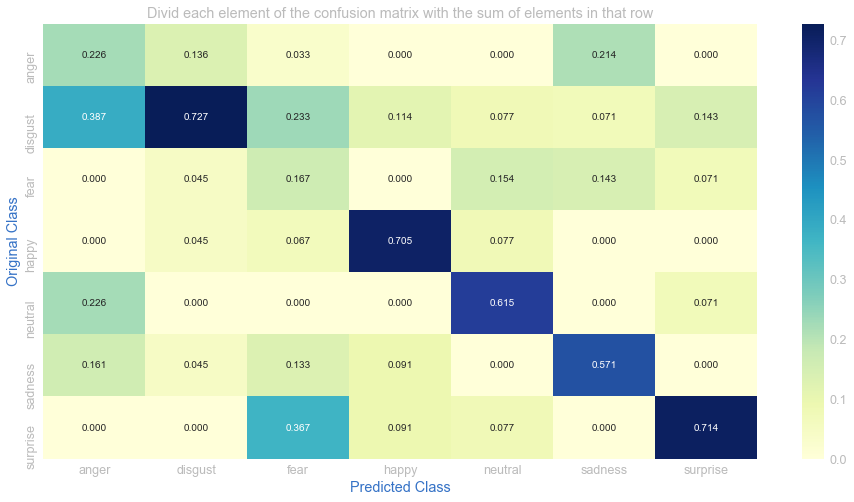

In [37]:
shape2 = (168, 4997)
features = np.load(home+'tools/f'+str(shape2)+'.npy',allow_pickle=True)
labels = np.load(home+'tools/l'+str(shape2)+'.npy',allow_pickle=True)
score = loaded_model.score(features, labels)
print("## Accuracy = ",score*100,'%')
predict_labels = loaded_model.predict(features)
plot_confusion_matrix(labels, predict_labels, loaded_model.classes_)